<a href="https://colab.research.google.com/github/vitorscience/Data-Science/blob/main/Churn_Prediction_para_uma_empresa_de_Telecomunica%C3%A7%C3%B5es.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---
<img alt="Colaboratory logo" width="15%" src="https://raw.githubusercontent.com/carlosfab/escola-data-science/master/img/novo_logo_bg_claro.png">

#### **Data Science na Prática 4.0**
*by [Vitor Batista](https://github.com/vitorscience)*  

---

# Churn Prediction

*Churn rate*, ou simplesmente *churn*, representa a taxa de evasão da sua base de clientes. Em serviços como Spotify ou Netflix, ela representaria a taxa de cancelamento de assinaturas.

<p align=center>
<img src="https://raw.githubusercontent.com/carlosfab/dsnp2/master/img/churnrate.jpg" width="60%"></p>

Ela é de extrema importância para a administração e sua análise ao longo do tempo pode mostrar que existe algum problema que deve ser atacado.

*Churn* também pode ser usado para identificar potenciais cancelamentos, com um tempo de antecedência, e promover ações direcionadas para tentar reter tais clientes. Essa métrica deve receber atenção pelo fato de que o Custo de Aquisição de Cliente (CAC) é normalmente mais alto que o custo para mantê-los. Ou seja, um alto valor para o *churn rate* é o que não desejamos.

## Aquisição dos Dados

Os dados utilizados neste projeto foram originalmente disponibilizados na [plataforma de ensino da IBM Developer](https://developer.ibm.com/technologies/data-science/patterns/predict-customer-churn-using-watson-studio-and-jupyter-notebooks/#), e tratam de um problema típico de uma companhia de telecomunicações. O *dataset* completo pode ser encontrado [neste link](https://raw.githubusercontent.com/carlosfab/dsnp2/master/datasets/WA_Fn-UseC_-Telco-Customer-Churn.csv).

Apesar de não haver informações explícitas disponíves, os nomes das colunas permitem um entendimento a respeito do problema.

In [1]:
# instalar Pandas Profiling
!pip install scikit-plot -q
!pip install imbalanced-learn -q
!pip install scikit-plot -q
!pip install --upgrade scikit-plot -q
!pip install lifelines -q

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.3/349.3 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.5/94.5 kB 4.5 MB/s eta 0:00:00


In [2]:
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from imblearn.under_sampling import RandomUnderSampler
from scipy.interpolate import interp1d
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, confusion_matrix, classification_report
from sklearn.metrics import confusion_matrix
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


In [3]:
# importar os pacotes necessários


# importar os dados
DATA_PATH = "https://raw.githubusercontent.com/carlosfab/dsnp2/master/datasets/WA_Fn-UseC_-Telco-Customer-Churn.csv"
df = pd.read_csv(DATA_PATH)

# ver as 5 primeiras entradas
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [4]:
#Avaliando as variáveis
df.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

In [5]:
df_clean = df.copy()

# Dicionário de variáveis:
1. customerID: Identificador único do cliente.
2. gender: Gênero do cliente.
3. SeniorCitizen: Indica se o cliente é idoso (1 para sim, 0 para não).
4. Partner: Indica se o cliente tem um cônjuge/companheiro(a) (Sim ou Não).
5. Dependents: Indica se o cliente tem dependentes (Sim ou Não).
6. tenure: Tempo (em meses) que o cliente está com a empresa.
7. PhoneService: Indica se o cliente tem serviço de telefone (Sim ou Não).
8. MultipleLines: Indica se o cliente tem múltiplas linhas telefônicas.
9. InternetService: Tipo de serviço de internet (DSL, Fibra, ou Nenhum).
10. OnlineSecurity: Indica se o cliente tem segurança online (Sim, Não, ou Sem internet).
11. OnlineBackup: Indica se o cliente tem backup online (Sim, Não, ou Sem internet).
12. DeviceProtection: Indica se o cliente tem proteção para dispositivos (Sim,  Não, ou Sem internet).
13. TechSupport: Indica se o cliente tem suporte técnico (Sim, Não, ou Sem internet).
14. StreamingTV: Indica se o cliente tem streaming de TV (Sim, Não, ou Sem internet).
15. StreamingMovies: Indica se o cliente tem streaming de filmes (Sim, Não, ou Sem internet).
16. Contract: Tipo de contrato (Mensal, 1 ano, ou 2 anos).
17. PaperlessBilling: Indica se o cliente optou por fatura eletrônica (Sim ou Não).
18. PaymentMethod: Método de pagamento do cliente.
19. MonthlyCharges: Valor que o cliente paga mensalmente.
20. TotalCharges: Total que o cliente pagou até agora.
21. Churn: Indica se o cliente cancelou o serviço (Sim ou Não).


# Soluções para Redução de Churn
Grandes empresas adotam diversas estratégias para reduzir o churn e reter clientes, focando em personalização, engajamento e experiência do usuário. Aqui estão alguns exemplos de como elas implementam essas estratégias:

* Google: O Google utiliza análises avançadas e inteligência artificial para prever o comportamento dos clientes e oferecer soluções personalizadas. Isso permite antecipar as necessidades dos usuários e resolver potenciais problemas antes que eles considerem cancelar o serviço.

* Netflix: A Netflix usa algoritmos sofisticados para personalizar as recomendações de conteúdo, o que aumenta o engajamento dos usuários. Ao oferecer conteúdo relevante, a empresa mantém os clientes interessados e reduz a probabilidade de cancelamento.

* LinkedIn: O LinkedIn mantém seus usuários engajados através de atualizações constantes de conteúdo, notificações personalizadas e sugestões de conexões profissionais. Esse engajamento contínuo ajuda a reter usuários ativos na plataforma, diminuindo o churn.

Essas práticas demonstram como a combinação de tecnologia e foco no cliente pode ser eficaz na retenção e na criação de valor contínuo para os usuários.

#Solução Proposta:

Para reduzir o churn nesta empresa de telecomunicações, será utilizada uma abordagem baseada em Machine Learning. Essa solução permitirá analisar as variáveis relacionadas aos clientes, identificando padrões e comportamentos que indicam a probabilidade de cancelamento.

#Análise Exploratória

Nesta etapa, será realizado um processo de limpeza dos dados, preparando-os para as próximas fases da análise.

In [6]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [7]:
#Analisando a variável TotalCharges
#df_clean.TotalCharges.unique()

In [8]:
# Substituir espaços em branco por NaN
df_clean['TotalCharges'] = df_clean['TotalCharges'].replace(' ', pd.NA)

# Converter a coluna para float, forçando valores não numéricos a se tornarem NaN
df_clean['TotalCharges'] = pd.to_numeric(df_clean['TotalCharges'], errors='coerce')
df_clean['TotalCharges'] = df_clean['TotalCharges'].fillna(0)

Analisando o DataFrame pelo método describe, não há indícios de outliers.

In [9]:
df_clean.describe()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
count,7043.000000,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692,2279.734304
std,0.368612,24.559481,30.090047,2266.794470
min,0.000000,0.000000,18.250000,0.000000
25%,0.000000,9.000000,35.500000,398.550000
50%,0.000000,29.000000,70.350000,1394.550000
75%,0.000000,55.000000,89.850000,3786.600000
max,1.000000,72.000000,118.750000,8684.800000


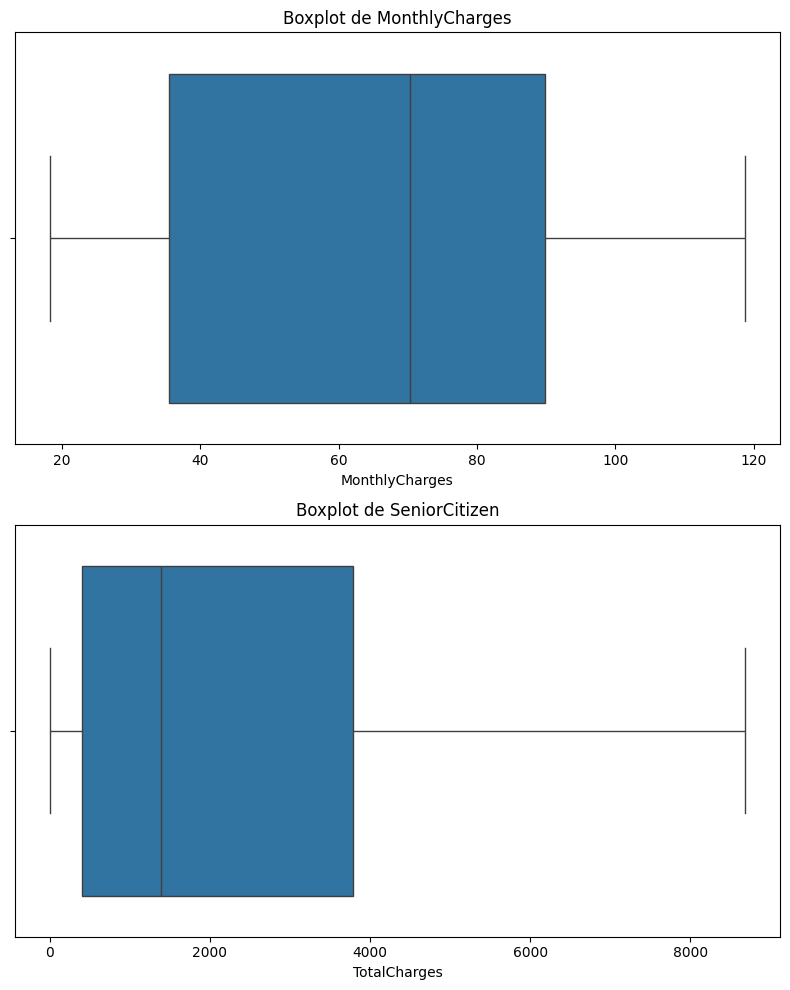

In [10]:
# Criar a figura com 2 linhas e 1 coluna
fig, ax = plt.subplots(ncols=1, nrows=2, figsize=(8, 10))

# Criar o boxplot para 'MonthlyCharges'
sns.boxplot(x=df_clean['MonthlyCharges'], ax=ax[0])
ax[0].set_title('Boxplot de MonthlyCharges')

# Criar o boxplot para 'SeniorCitizen'
sns.boxplot(x=df_clean['TotalCharges'], ax=ax[1])
ax[1].set_title('Boxplot de SeniorCitizen')

# Ajustar o layout para não sobrepor os gráficos
plt.tight_layout()

# Mostrar os gráficos
plt.show()

Conforme analisado no boxplot, o dataframe não contém outliers

In [11]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [12]:
df_clean.isnull().sum().sum()

0

In [13]:
# Obtendo valores únicos das colunas do tipo 'object'
valores_unicos = np.unique(df_clean.drop(['customerID', 'TotalCharges'], axis=1).select_dtypes('object').values)

# Configurar o NumPy para exibir arrays completos
np.set_printoptions(threshold=np.inf)

# Exibir todos os valores únicos
print(valores_unicos)

['Bank transfer (automatic)' 'Credit card (automatic)' 'DSL'
 'Electronic check' 'Female' 'Fiber optic' 'Mailed check' 'Male'
 'Month-to-month' 'No' 'No internet service' 'No phone service' 'One year'
 'Two year' 'Yes']


In [14]:
df_clean['Churn'] = df_clean['Churn'].replace({'No': 0, 'Yes': 1})

# Análise Exploratória

Nesta etapa do processo, serão analisadas as variáveis do projeto e identificadas as tendências presentes no banco de dados.


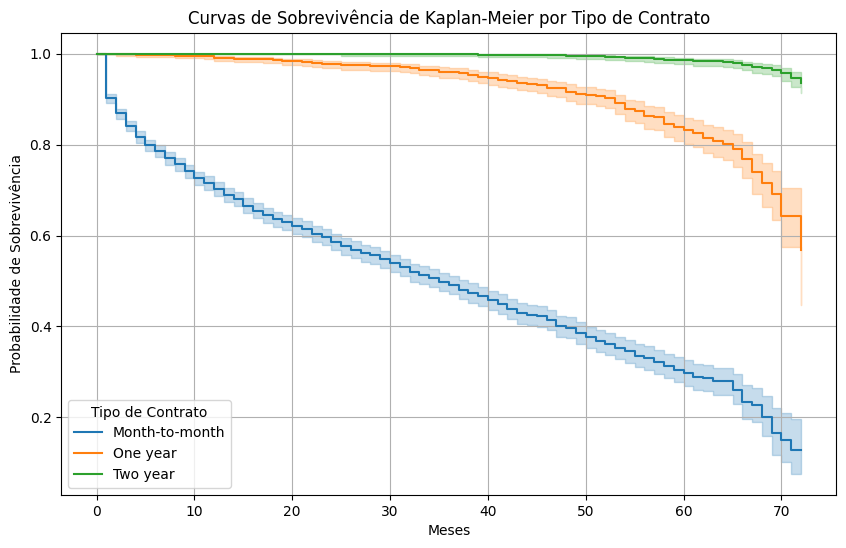

In [15]:
# Supondo que df_clean já esteja carregado, se não, carregue o DataFrame aqui
# df_clean = pd.read_csv('seu_arquivo.csv')
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt


# Inicialize o KaplanMeierFitter
kmf = KaplanMeierFitter()

# Prepare a figura
plt.figure(figsize=(10, 6))

# Iterar sobre cada tipo de contrato e ajustar o modelo Kaplan-Meier
for contrato in df_clean['Contract'].unique():
    # Filtrar os dados para o tipo de contrato
    dados = df_clean[df_clean['Contract'] == contrato]

    # Ajustar o modelo Kaplan-Meier
    kmf.fit(dados['tenure'], event_observed=dados['Churn'], label=contrato)

    # Plotar a curva
    kmf.plot_survival_function()

# Adicionar título e rótulos
plt.title('Curvas de Sobrevivência de Kaplan-Meier por Tipo de Contrato')
plt.xlabel('Meses')
plt.ylabel('Probabilidade de Sobrevivência')
plt.legend(title='Tipo de Contrato')
plt.grid(True)
plt.show()

O gráfico de **Kaplan-Meier** permite a comparação entre grupos, mostrando a curva de sobrevivência ao longo do tempo estimado. Ao avaliar a curva de sobrevivência, observa-se que os clientes com contrato mês a mês tendem a **cancelar** mais rapidamente.


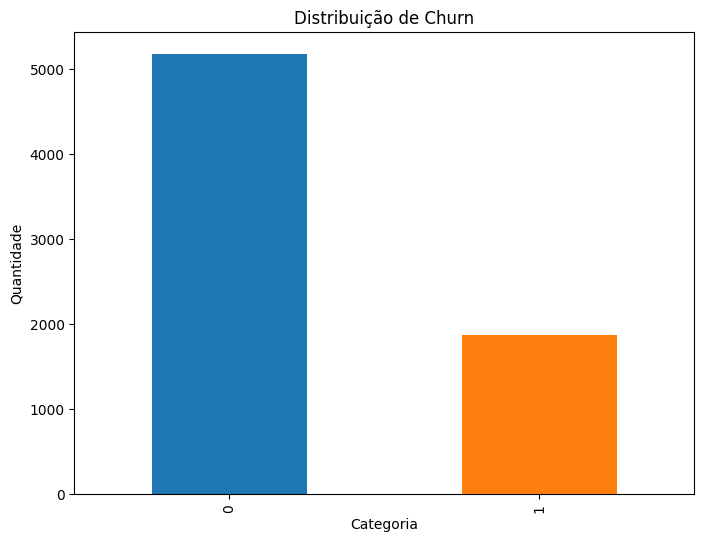

In [16]:
# Contagem de Churn
contagem_churn = df_clean['Churn'].value_counts()

# Criar a figura e o eixo
fig, ax = plt.subplots(figsize=(8, 6))

# Plotar o gráfico de barras com as cores definidas
contagem_churn.plot(kind='bar', color=('#1f77b4', '#ff7f0e'), ax=ax)

# Definir o título e os rótulos
ax.set_title('Distribuição de Churn')
ax.set_ylabel('Quantidade')
ax.set_xlabel('Categoria')

# Mostrar o gráfico
plt.show()

Conforme o gráfico de destribuição apresenta, o data frame esta desbalancedo em relação a churn

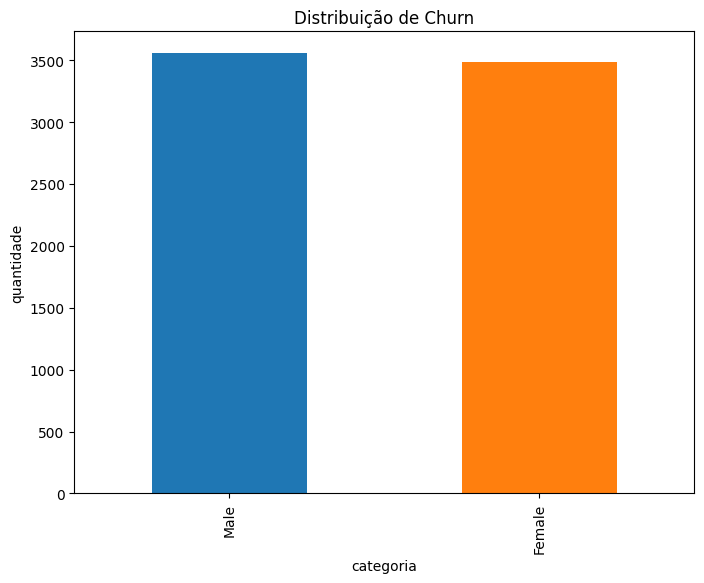

In [17]:
contagem_churn = df_clean.gender.value_counts()
fig, ax = plt.subplots(figsize=(8, 6))
contagem_churn.plot(kind='bar', color=('#1f77b4', '#ff7f0e'))
ax.set_title('Distribuição de Churn')
ax.set_ylabel('quantidade')
ax.set_xlabel('categoria')
plt.show()

<ipython-input-18-268603d724c8>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=contagem_tenure.index, y=contagem_tenure.values, palette=cores, ax=ax)


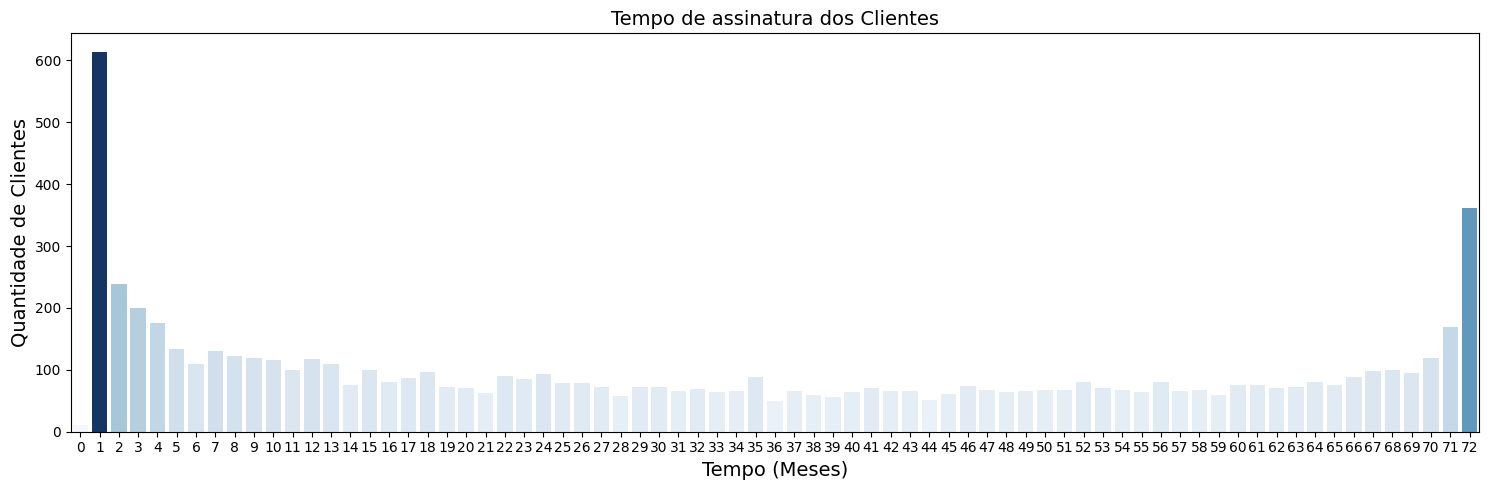

In [18]:
# Calcular a contagem para cada valor de 'tenure'
contagem_tenure = df_clean['tenure'].value_counts().sort_index()

# Definir uma paleta de cores baseada nas contagens, com maior intensidade para valores maiores
paleta = sns.color_palette('Blues', len(contagem_tenure))
cores = [paleta[int((n / max(contagem_tenure)) * (len(paleta) - 1))] for n in contagem_tenure]

# Plotar o gráfico
fig, ax = plt.subplots(figsize=(15, 5))
sns.barplot(x=contagem_tenure.index, y=contagem_tenure.values, palette=cores, ax=ax)

# Definir o título e os rótulos dos eixos
ax.set_title('Tempo de assinatura dos Clientes', fontsize=14)
ax.set_ylabel('Quantidade de Clientes', fontsize=14)
ax.set_xlabel('Tempo (Meses)', fontsize=14)

# Ajustar layout
plt.tight_layout()
plt.show()

In [19]:
df_clean = df_clean.drop(['customerID'], axis=1)


<Axes: >

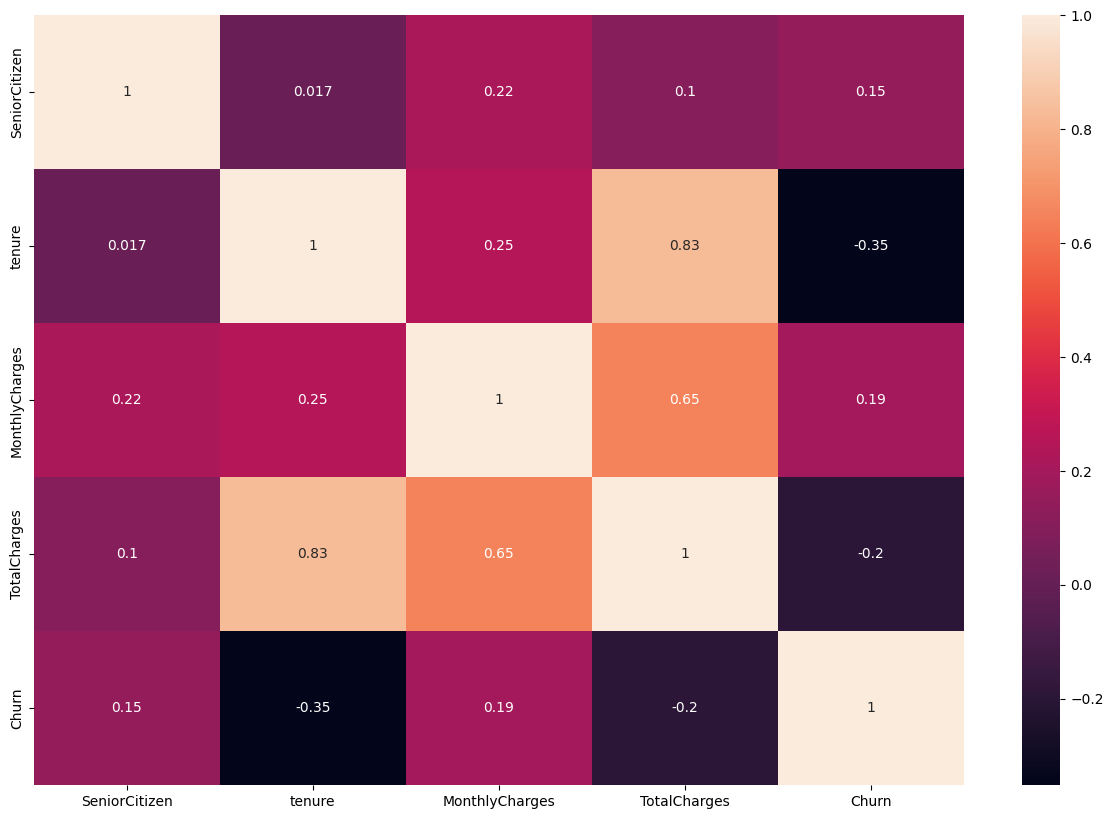

In [20]:
corr=df_numeric = df_clean.select_dtypes(include=[float, int]).corr()
plt.figure(figsize=(15,10))
sns.heatmap(corr, annot=True)

A váriavel gerenero esta balanceada no data frame.

# Preparando as variáveis

Nesta etapa, será realizado um pré-processamento das variáveis, tratando cada tipo separadamente, dividindo-as em variáveis categóricas e numéricas. Após isso, será aplicado o label encoding e o one-hot encoding.

In [21]:
binary_var = df_clean.nunique()[df_clean.nunique() == 2].keys().tolist()
num_var = [col for col in df_clean.select_dtypes(['int', 'float']).columns.tolist() if col not in binary_var]
cat_var = [col for col in df_clean.columns.tolist() if col not in binary_var + num_var]

# Criar uma cópia do DataFrame
df_proc = df_clean.copy()

# Label Encoding para as variáveis binárias
le = LabelEncoder()
for i in binary_var:
    df_proc[i] = le.fit_transform(df_proc[i])

# Aplicar get_dummies nas colunas categóricas
df_proc = pd.get_dummies(df_proc, columns=cat_var)

# Garantir que todas as colunas sejam inteiras
df_proc = df_proc.astype(int)

# Mostrar as 5 primeiras entradas
df_proc.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,...,StreamingMovies_No,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,0,1,0,1,0,1,29,29,0,...,1,0,0,1,0,0,0,0,1,0
1,1,0,0,0,34,1,0,56,1889,0,...,1,0,0,0,1,0,0,0,0,1
2,1,0,0,0,2,1,1,53,108,1,...,1,0,0,1,0,0,0,0,0,1
3,1,0,0,0,45,0,0,42,1840,0,...,1,0,0,0,1,0,1,0,0,0
4,0,0,0,0,2,1,1,70,151,1,...,1,0,0,1,0,0,0,0,1,0


<Axes: >

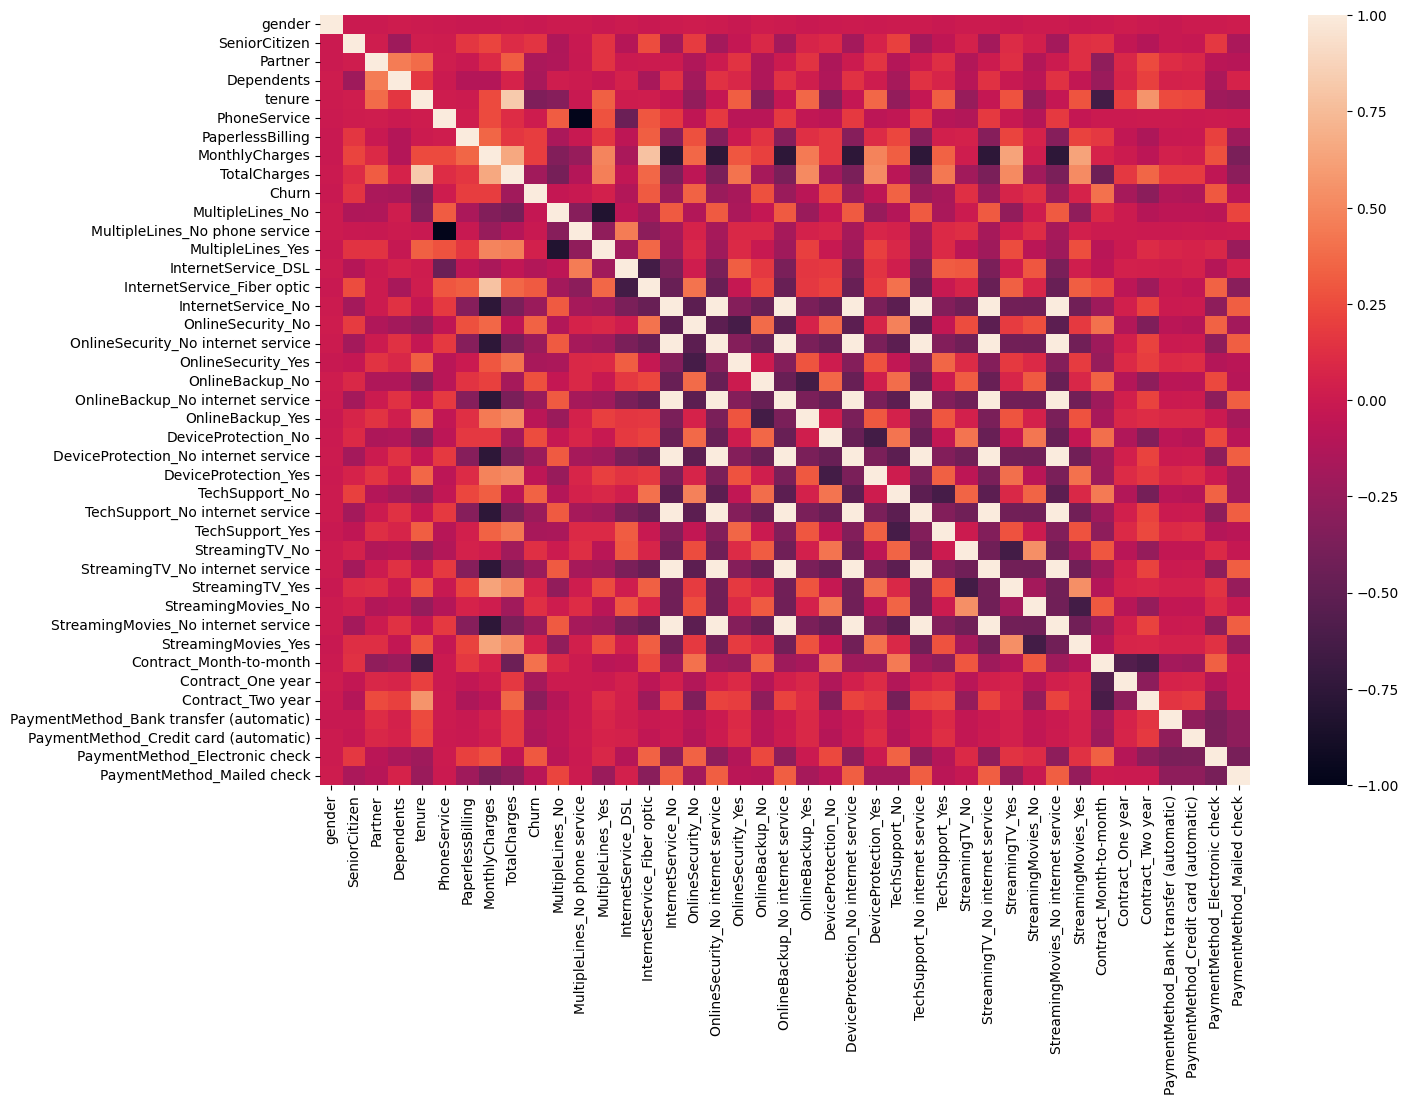

In [22]:
corr2 = df_proc.select_dtypes(include=[int]).corr()
plt.figure(figsize=(15,10))
sns.heatmap(corr2)


# Modelo de Machine Learning



In [23]:
#Separando os dados
X=df_proc.drop('Churn', axis=1)
y=df_proc.Churn

# Dividindo os resultados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X,y)

In [24]:
#Pipeline

def val_model(X,y, clf,quite=False):
  X=np.array(X)
  y=np.array(y)
  pipeline=(make_pipeline(StandardScaler(), clf ))
  scores=cross_val_score(pipeline, X, y, scoring='recall')

  if quite == False:
      print("Recall: {:.2f} (+/- {:.2f})".format(scores.mean(), scores.std()))

  return scores.mean()



In [25]:
seed=42

In [26]:
rf =RandomForestClassifier()
val_model(X_train, y_train,rf)

Recall: 0.50 (+/- 0.01)


0.5031505080285568

Realizando o balanceamento de dados

In [27]:
# Normalizando os dados para deixá-los na mesma escala
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)

# Balanceando os dados com undersampling
rus = RandomUnderSampler()
X_train_rus, y_train_rus = rus.fit_resample(X_train_scaled, y_train)

In [28]:
dtc=DecisionTreeClassifier()
lr=LogisticRegression()
xgb=XGBClassifier()
knc=KNeighborsClassifier()
lda= LinearDiscriminantAnalysis()
val_model(X_train_rus, y_train_rus,dtc)
val_model(X_train_rus, y_train_rus,lr)
val_model(X_train_rus, y_train_rus,xgb)
val_model(X_train_rus, y_train_rus,lda)
val_model(X_train_rus, y_train_rus,knc)

Recall: 0.68 (+/- 0.01)
Recall: 0.81 (+/- 0.02)
Recall: 0.76 (+/- 0.01)
Recall: 0.79 (+/- 0.01)
Recall: 0.79 (+/- 0.02)


0.7875660924441411

O modelo que apresentou o melhor desempenho durante os treinamentos foi a Regressão Logística, com um Recall de 81%. Dado o resultado positivo, será aplicado o Cross-Validation e o GridSearch para otimizar ainda mais os dados e ajustar os hiperparâmetros, visando melhorar o desempenho do modelo.

Parâmetros utilizados para regressão Logística

* penalty: Tipo de regularização a ser aplicada.
* C: Parâmetro de regularização que controla a força da regularização.
* solver: Algoritmo de otimização usado para encontrar os parâmetros do modelo.


In [29]:
# Definir o grid de hiperparâmetros
param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1],
    'colsample_bytree': [0.8, 1],
    'gamma': [0, 0.1, 0.2]
}

# Criar o modelo
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# Configurar o GridSearchCV
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid,
                           scoring='roc_auc', cv=5, n_jobs=-1)

# Ajustar o modelo
grid_search.fit(X_train_rus, y_train_rus)

# Melhor combinação de parâmetros
print("Melhor combinação de parâmetros:", grid_search.best_params_)
print("Melhor pontuação (AUC): {:.4f}".format(grid_search.best_score_))

# Avaliar o melhor modelo
best_xgb = grid_search.best_estimator_

# Previsão
y_pred_xgb = best_xgb.predict(X_test)

# Área sob a curva ROC
auc = roc_auc_score(y_test, y_pred_xgb)
print("AUC: {:.4f}".format(auc))

# Matriz de Confusão
cm = confusion_matrix(y_test, y_pred_xgb)
print("Matriz de Confusão:\n", cm)

# Relatório de Classificação
report = classification_report(y_test, y_pred_xgb)
print("Relatório de Classificação:\n", report)

Melhor combinação de parâmetros: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}
Melhor pontuação (AUC): 0.8470
AUC: 0.5000
Matriz de Confusão:
 [[1323    0]
 [ 438    0]]
Relatório de Classificação:
               precision    recall  f1-score   support

           0       0.75      1.00      0.86      1323
           1       0.00      0.00      0.00       438

    accuracy                           0.75      1761
   macro avg       0.38      0.50      0.43      1761
weighted avg       0.56      0.75      0.64      1761



/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [00:47:28] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 

In [30]:
param_grid = {
        'penalty': ['l1', 'l2', 'elasticnet', 'none'],
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga']
}

In [31]:
grid = GridSearchCV(LogisticRegression(), param_grid, cv=5, scoring='recall')
grid.fit(X_train_rus, y_train_rus)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': [0.01, 0.1, 1, 10, 100],
                         'penalty': ['l1', 'l2', 'elasticnet', 'none'],
                         'solver': ['lbfgs', 'liblinear', 'newton-cg',
                                    'newton-cholesky', 'sag', 'saga']},
             scoring='recall')

In [32]:
grid.best_params_

{'C': 0.01, 'penalty': 'l1', 'solver': 'liblinear'}

In [33]:
from sklearn.decomposition import PCA


In [34]:
param_grid = {
        'penalty': ['l1', 'l2', 'elasticnet', 'none'],
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga']
}

# Modelagem sem PCA

In [35]:
#Modelo de regressão
lr = LogisticRegression(C=0.01, penalty='l1', class_weight='balanced', solver='liblinear')
lr.fit(X_train_rus, y_train_rus)


# Previsão
X_test_lr = scaler.transform(X_test)
y_pred_lr = lr.predict(X_test)

# Área sob a curva ROC
auc = roc_auc_score(y_test, y_pred_lr)
print("AUC: {:.4f}\n".format(auc))

# Matriz de Confusão#
cm = confusion_matrix(y_test, y_pred_lr)
print("Matriz de Confusão:\n", cm)

# Relatório de Classificação
report = classification_report(y_test, y_pred_lr)
print("Relatório de Classificação:\n", report)

AUC: 0.5800

Matriz de Confusão:
 [[1293   30]
 [ 358   80]]
Relatório de Classificação:
               precision    recall  f1-score   support

           0       0.78      0.98      0.87      1323
           1       0.73      0.18      0.29       438

    accuracy                           0.78      1761
   macro avg       0.76      0.58      0.58      1761
weighted avg       0.77      0.78      0.73      1761



/usr/local/lib/python3.10/dist-packages/sklearn/base.py:458: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


# Modelagem com PCA


In [36]:
# Primeiro, é importante padronizar as features para que todas tenham a mesma escala
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Agora, aplicando o PCA com 10 componentes principais
pca = PCA(n_components=10)
X_pca = pca.fit_transform(X_scaled)

# Dividindo os dados em conjuntos de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.3, random_state=seed)

# Treinando o modelo de Regressão Logística
lr2 = LogisticRegression(C=0.01, penalty='l1', class_weight='balanced', solver='liblinear')
lr2.fit(X_train, y_train)

# Fazendo previsões no conjunto de teste
y_pred = lr2.predict(X_test)

# Prevendo as probabilidades para calcular a AUC
y_pred_proba = lr2.predict_proba(X_test)[:, 1]

# Calculando a AUC
auc = roc_auc_score(y_test, y_pred_proba)
print(f"AUC: {auc:.2f}")

# Avaliando o modelo
print(classification_report(y_test, y_pred))



AUC: 0.84
              precision    recall  f1-score   support

           0       0.92      0.70      0.80      1539
           1       0.51      0.83      0.63       574

    accuracy                           0.74      2113
   macro avg       0.71      0.77      0.71      2113
weighted avg       0.81      0.74      0.75      2113



#Conclusão

O segundo modelo, com uma AUC de 0.84, demonstra ser claramente superior ao primeiro, que apresentou uma AUC de 0.58. Esse modelo alcança um equilíbrio melhor entre recall e precisão, especialmente na identificação da classe 1, o que é essencial para melhorar a performance na detecção dessa classe. O primeiro modelo, por outro lado, falha significativamente em capturar a classe 1, resultando em um desempenho desequilibrado e insatisfatório.

A superioridade do segundo modelo deve-se à implementação do PCA (Análise de Componentes Principais), que contribuiu para a redução da dimensionalidade e a prevenção do overfitting. Essas melhorias permitiram que o modelo se concentrasse nas características mais relevantes, resultando em uma classificação mais precisa e eficaz.